### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Copie este notebook y **modifique el nombre de archivo** agregando los apellidos de ambos miembros. Por ejemplo si los miembros del grupo son Pablo Huijse y Ana Nuñez el nombre sería: `info147_tarea2_huijse_nuñez.ipynb`
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña Puede agregar a su compañero en la pestaña *Settings/Manage access*
1. Sean leales y honestos, no copie los resultados de otros grupos, el único afectado es usted
1. Se evaluará el último commit antes de la fecha y hora de entrega

# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







## Introducción

En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos para comprobar o refutar los hallazgos de *D. Treisman*

## Datos

Para esta tarea se les provee de un conjunto de datos indexado por país con los siguientes atributos
- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [122]:
import pandas as pd
df = pd.read_csv('billonarios.csv', index_col='pais')
df.head(30)

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0
Cuba,0,8.590968,16.239990,8
Haiti,0,6.521256,16.081251,58
Dominican Republic,0,8.491694,16.092798,58
Jamaica,0,8.542905,14.798313,45


## Modelo

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> Note que el número de billonarios es una variable entera y no-negativa. Un modelo de regresión con verosimilitud Gaussiano no es apropiado

Se pide entonces que use una [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), definimos entonces la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 
- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

Considerando esto, se pide que

> Ajuste $\theta$ mediante la maximización de la verosimilitud

En primer lugar se pide que
1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es grande?
1. Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema
1. Obtenga y muestre una expresión analítica para la primera deriviada del logaritmo de la verosimilitud

In [123]:
%matplotlib notebook

In [180]:
import numpy as np
# Importamos la librería
import matplotlib as mpl
display(mpl.__version__)
import matplotlib.pyplot as plt
from scipy.special import factorial as fact
import pandas as pd
import scipy.optimize
from sklearn import metrics, model_selection, preprocessing
from sklearn.model_selection import train_test_split

'3.1.3'

#### 1.  Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro  𝜆 , ¿Qué ocurre cuando  𝜆  es grande?

La regresión de Poisson es una distribucion de probabilidad discreta. Y representa el número de ocurrencias, lambda corresponde a la tasa esperada de ocuurrencias. X es el vector de atributos del país (Población, PIB y años en GATT en nuestro caso).

La distribución de Poisson es un modelo apropiado si se cumplen las siguientes condiciones:

* k es el número de veces que un evento ocurre en un intervalo y puede tomar valores enteros mayores que -1.
* Los eventos ocurren de forma independiente.
* La tasa promedio en la que los eventos ocurren es independiente de cualquier ocurrencia. Es además constante.
* Dos eventos no pueden ocurrir al mismo instante.

**λ = 1** Evento que en promedio ocurre una vez por intervalo: k0 = k1 = 0.37 

A medida que lambda incrementa, la probabilidad de eventos en un intervalo se asemeja más y más a una distribución normal, donde el número de eventos k  con mayor probabilidad es igual a lambda (al valor entero más cercano).


In [155]:
def poisonxd(lmbd, y):
    return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
    #return (lmbd**y/fact(y)) * np.exp(-lmbd)

<IPython.core.display.Javascript object>


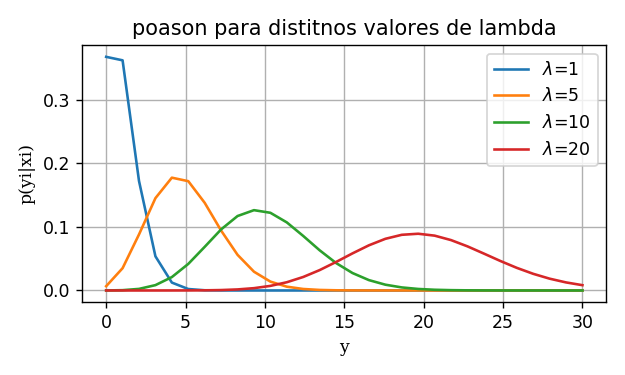

In [156]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True, facecolor='w')
# Tipos de linea: -, --, -., :, none
# Tipos de markers: .,o,x,d,s,1,2,3,4
y = np.linspace(start=0, stop=30, num=30)


#incorporar un intSlider para los valores de lambda?
for i in [1, 5, 10, 20]:
    values = [poisonxd(i, val) for val in y]
    plt.plot(y, values, label=f'$\lambda$={i}')
    
    
ax.set_ylabel('p(yi|xi)', fontsize=10, fontname='serif', color="black")
ax.set_xlabel('y', fontsize=10, fontname='serif', color="black")
ax.set_title('poason para distitnos valores de lambda')    
ax.grid()
ax.legend()
plt.show()

###### Aplique el supuesto iid. Obtenga y muestre una expresión analítica para el logaritmo de la verosimilitud del problema

$$
\begin{align}
\mathcal{L}(\theta) &= \prod_{i=1}^N P(y_i|\theta) \nonumber \\
\mathcal{L}(\theta) &= \prod_{i=1}^N \frac{\lambda_i^{y_i}}{y_i!} e^\left ({-\lambda_i} \right) \nonumber \\
\end{align}
$$
aplicando ln se tiene
$$
\begin{align}
\ln \mathcal{L}(\theta) &= \sum_{i=1}^N \ln (\frac{\lambda_i^{y_i}}{y_i!})-\lambda_i \nonumber \\
\ln \mathcal{L}(\theta) &=  \sum_{i=1}^N \ln (\lambda_i^{y_i}) - \ln (y_i!)-\lambda_i \nonumber \\
\ln \mathcal{L}(\theta) &=  \sum_{i=1}^N {y_i} \ln (\lambda_i) - \ln (y_i!)-\lambda_i \nonumber \\
\end{align}
$$

In [166]:
y = df['nbillonarios'].values
#-2.96210167e+01
bestTheta = [ -29.0495,  1.0839 , 1.1714,  0.0060]
#bestTheta0 = best_theta[0]
bestTheta0 = -2.96210167e+01 
lmbd0 = np.ones(shape=(len(y), 1)) * abs(bestTheta[0])
#display(lmbd0)
logBestTheta0 = np.sum((y * np.log(lmbd0) - lmbd0))

#display(logBestTheta0)
#display(neglogverosimilitud(bestTheta, *(X, y)))

R2 = (logBestTheta0 + neglogverosimilitud(bestTheta, *(X, y))) / logBestTheta0
display(R2)

<ipython-input-165-31921073721f>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
<ipython-input-165-31921073721f>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)


1.0089759466623356

## Implementación

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`
1. Encuentre el vector de parámetros óptimo usando `scipy.optimize.minimize`, justifique su decisión para el método y argumentos a usar
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y para el pseudo coeficiente de correlación


In [54]:
import statsmodels.api as sm

df['const'] = 1

reg1 = ['const','logpibpc', 'logpob', 'gatt']

poisson_reg = sm.Poisson(df['nbillonarios'], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:           nbillonarios   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Aug 2020   Pseudo R-squ.:                  0.8574
Time:                        17:40:19   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
logpibpc       1.0839      0.

In [ ]:
import pandas as pd
df = pd.read_csv('billonarios.csv', index_col='pais')
df.head(30)

In [165]:
def poisonxd(lmbd, y):
    return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
    #return (lmbd**y/fact(y)) * np.exp(-lmbd)


In [130]:
def modelo(theta, X, Y):
    lmbd = np.exp(theta[0] + np.sum(theta[1:]*X, axis=1))
    return poisonxd(lmbd, Y), lmbd

    #f = theta[0] + np.sum(theta[1:]*X, axis=1)     
    #return sigmoide(f), f

In [131]:
def neglogverosimilitud(theta, *args):
    X,Y = args
    P, lmbd = modelo(theta, X,Y)
    #-np.sum(-np.logaddexp(0, -f) - (1-y)*f, axis=0)
    #return -np.sum((Y * np.log(lmbd + 1e-10) - lmbd - fact(Y)), axis=0)
    return -np.sum((Y * np.log(lmbd + 1e-10) - lmbd), axis=0)
    

In [132]:
def grad_neglogverosimilitud(theta, *args):
    X, y = args
    N = len(y)
    s, f = modelo(theta, X, y)
    suma1 = np.sum(X, axis=1)
    suma = (np.ones(shape=(N, theta.shape[0] - 1)) * suma1[:, np.newaxis])
    X1 = np.concatenate((np.ones(shape=(N, 1)), suma), axis=1)
    #display((y - f)[:, np.newaxis] * X1)
    return ((y - f)[:, np.newaxis] * X1)

In [208]:
df = pd.read_csv('billonarios.csv', index_col='pais')
display(df.head(5))

#df = df.drop('United States')
y = df['nbillonarios'].values

x=df.drop(['nbillonarios'], axis=1)
X=x.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)


#thetacool = [ -29.0495,  1.0839 , 1.1714,  0.0060]


,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0


In [211]:
# Usaremos un callback para guardar el mejor modelo de validación
def eval_model(theta):  
    global best_theta, best_logl
    logltrain = neglogverosimilitud(theta, *(X_train, y_train))
    logltest = neglogverosimilitud(theta, *(X_test, y_test))
    print("Train: %0.4f, Test: %0.4f" %(logltrain, logltest))   
    if logltest < best_logl: # Guardar el mejor modelo de test
        best_theta = theta
        best_logl = logltest
        
        
# Valor inicial de theta
theta = np.random.randn(1+X.shape[1])
#theta = [-0.55402165, -0.2629835 , -1.05047187, -0.53265773]
# Mejor valor de theta
best_theta = np.zeros(1+X.shape[1])
# Mejor valor de la verosimilitud
best_logl = np.inf
res = scipy.optimize.minimize(fun=neglogverosimilitud, x0=theta, 
                              method='CG', jac=False, 
                              args=(X_train, y_train),
                              callback=eval_model, tol=1e-1)

print(res.message)
display(best_theta)
        

Train: 5613.7843, Test: 17538.6257
Train: 5613.6754, Test: 17554.0288
Train: 1454.0426, Test: 4132.7001
Train: 1413.3195, Test: 3872.9223
Train: 722.1762, Test: 2176.8469
Train: 718.0817, Test: 2159.3632
Train: 639.0860, Test: 1933.2862
Train: 633.5029, Test: 1909.4430
Train: 595.4792, Test: 1784.6627
Train: 467.8970, Test: 1321.3919
Train: -44.5316, Test: -422.8328
Train: -47.9763, Test: -468.2954
Train: -56.1345, Test: -555.9131
Train: -184.0290, Test: -1077.1534
Train: -240.5105, Test: -1117.7308
Train: -240.5461, Test: -1120.5685
Train: -240.5627, Test: -1123.7359
Train: -242.5125, Test: -1125.2191
Train: -242.5781, Test: -1119.6547
Train: -243.0108, Test: -1119.1904
Train: -243.2660, Test: -1132.2149
Train: -243.3884, Test: -1136.1047
Train: -243.4142, Test: -1132.5657
Train: -244.9325, Test: -1132.5034
Train: -244.9445, Test: -1135.0332
Train: -245.2812, Test: -1136.1535
Train: -245.3013, Test: -1139.5660
Train: -245.3439, Test: -1144.7886
Train: -245.6362, Test: -1145.7762
Train

<ipython-input-165-31921073721f>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
<ipython-input-165-31921073721f>:2: RuntimeWarning: invalid value encountered in multiply
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
<ipython-input-165-31921073721f>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
<ipython-input-165-31921073721f>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
<ipython-input-165-31921073721f>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)



Train: -560.9252, Test: -2770.8200
Train: -560.9418, Test: -2772.9377
Train: -560.9823, Test: -2771.6244
Train: -560.9961, Test: -2773.8218
Train: -561.0224, Test: -2773.2420
Train: -561.0293, Test: -2774.8929
Train: -561.0390, Test: -2774.7512
Train: -561.0433, Test: -2776.1030
Train: -561.0599, Test: -2777.1124
Train: -561.0621, Test: -2776.2533
Train: -561.1062, Test: -2777.8822
Train: -561.1920, Test: -2773.4796
Train: -561.2901, Test: -2776.5351
Train: -561.2910, Test: -2777.0692
Train: -561.2912, Test: -2777.3136
Train: -561.2968, Test: -2776.8729
Train: -561.2970, Test: -2776.6686
Train: -561.3003, Test: -2777.1097
Train: -561.3004, Test: -2777.3003
Train: -561.3109, Test: -2776.5362
Train: -561.3132, Test: -2777.4479
Train: -561.4058, Test: -2782.9303
Train: -561.8560, Test: -2777.7164
Train: -561.9095, Test: -2774.8398
Train: -562.1684, Test: -2783.7224
Train: -562.1692, Test: -2783.3281
Train: -562.1736, Test: -2784.1319
Train: -562.2160, Test: -2786.9155
Train: -562.3423, T

Train: -580.4261, Test: -2719.8760
Train: -580.4278, Test: -2717.4664
Train: -580.4280, Test: -2717.4681
Train: -580.4317, Test: -2721.8643
Train: -580.4318, Test: -2721.8478
Train: -580.4324, Test: -2723.1119
Train: -580.4330, Test: -2722.3821
Train: -580.4349, Test: -2721.1757
Train: -580.4350, Test: -2721.2508
Train: -580.4355, Test: -2719.5605
Train: -580.4355, Test: -2719.6499
Train: -580.4372, Test: -2719.8928
Train: -580.4373, Test: -2720.0160
Train: -580.4377, Test: -2721.5803
Train: -580.4377, Test: -2721.6837
Train: -580.4378, Test: -2722.5488
Train: -580.4378, Test: -2722.6277
Train: -580.4397, Test: -2726.3970
Train: -580.4398, Test: -2726.7502
Train: -580.4507, Test: -2733.6484
Train: -580.4509, Test: -2733.8904
Train: -580.4542, Test: -2732.2654
Train: -580.4543, Test: -2732.3261
Train: -580.4559, Test: -2731.2236
Train: -580.4561, Test: -2731.3327
Train: -580.4567, Test: -2731.3065
Train: -580.4604, Test: -2729.9542
Train: -580.4608, Test: -2729.8416
Train: -580.4684, Te

<ipython-input-165-31921073721f>:2: RuntimeWarning: overflow encountered in power
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)
<ipython-input-165-31921073721f>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.power(lmbd, y)/fact(y)) * np.exp(-lmbd)


array([-2.97484942e+01,  1.10292487e+00,  1.21897137e+00, -3.82213545e-04])

## Resultados

1. Prediga la cantidad de billonarios de cada país usando su modelo. Muestre la cantidad de billonarios predicha y real para cada continente. ¿Qué puede comentar al respecto?
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles paises tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 